In [2]:
%matplotlib notebook

We need more Public Domain Finnish sentences for Common Voice. One source could be the Finnish newspaper Ground Truth data from the National Library of Finland, as it contains old newspapers and has had a high quality proofreading. So this document just tracks the processing I did to get the current sentences.

The materials can be downloaded from [Digi service of the National Library of Finland](https://digi.kansalliskirjasto.fi/opendata/submit), by selecting file: OCR Ground Truth Pages (Finnish Fraktur) \[v1\](4.8 GB)

In [55]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

In [19]:
from pathlib import Path
from IPython.display import display
from pdf2image import convert_from_path, convert_from_bytes
import pytesseract
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from io import StringIO
import xml.etree.cElementTree as ET
import re

In [13]:
plt.rcParams['figure.figsize'] = [15, 15]

Here I define some functions that can be used later.

In [32]:
def pdf_to_pil(pdf_path):
    images = convert_from_path(pdf_path)
    return(images)

def image_to_pil(image_path):
    image = Image.open(image_path)
    return(image)

def ocr_pil_image(pil_image):
    content = pytesseract.image_to_data(pil_image, lang="rus")
    ocr_result = pd.read_csv(StringIO(content), sep="\t")
    return(ocr_result)


def plot_lines(page_image, ocr_result, level = 4):
    
    im = np.array(page_image)
    fig,ax = plt.subplots(1)
    ax.imshow(im)

    boxes = []

    word_level = ocr_result[ocr_result.level == level]
    word_areas = word_level[['left', 'top', 'width', 'height']].drop_duplicates()

    for left, top, width, height in zip(word_areas.left.to_list(), word_areas.top.to_list(), word_areas.width.to_list(), word_areas.height.to_list()):
        boxes.append(patches.Rectangle((left, top), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'None'))

    for line in boxes:
        ax.add_patch(line)

    plt.show()

def read_alto(alto_file, version = 2):
    
    tree = ET.parse(alto_file)
    root = tree.getroot()

    xmlns = {'alto': '{http://www.loc.gov/standards/alto/ns-v' + str(version) + '#}'}
    
    data = []

    unit = root.find('.//{alto}MeasurementUnit'.format(**xmlns)).text

    max_height = root.find('.//{alto}PrintSpace'.format(**xmlns)).get('HEIGHT')
    max_width = root.find('.//{alto}PrintSpace'.format(**xmlns)).get('WIDTH')

    for block in root.iterfind('.//{alto}TextBlock'.format(**xmlns)):
        
        block_id = block.get('ID')

        for line in block.iterfind('.//{alto}TextLine'.format(**xmlns)):

            content = {}

            content["block_id"] = block_id
            content["height"] = line.get('HEIGHT')
            content["width"] = line.get('WIDTH')
            content["top"] = line.get('VPOS')
            content["left"] = line.get('HPOS')
            content["unit"] = unit
            content["max_height"] = max_height
            content["max_width"] = max_width

            line_strings = []
            for string in line.findall('./{alto}String'.format(**xmlns)):
                
                word_content = string.get('CONTENT')
                
                if string.get('SUBS_TYPE') == 'HypPart1':
                
                    content['hyphenated'] = True
                
                    line_strings.append(word_content)
                    
                else:
                    
                    line_strings.append(word_content)
                    
                    content['hyphenated'] = False
                
                # ‑
            content["text"] = ' '.join(line_strings)
            
            data.append(content)
        
    return(data)

So let's check how the pages look like.

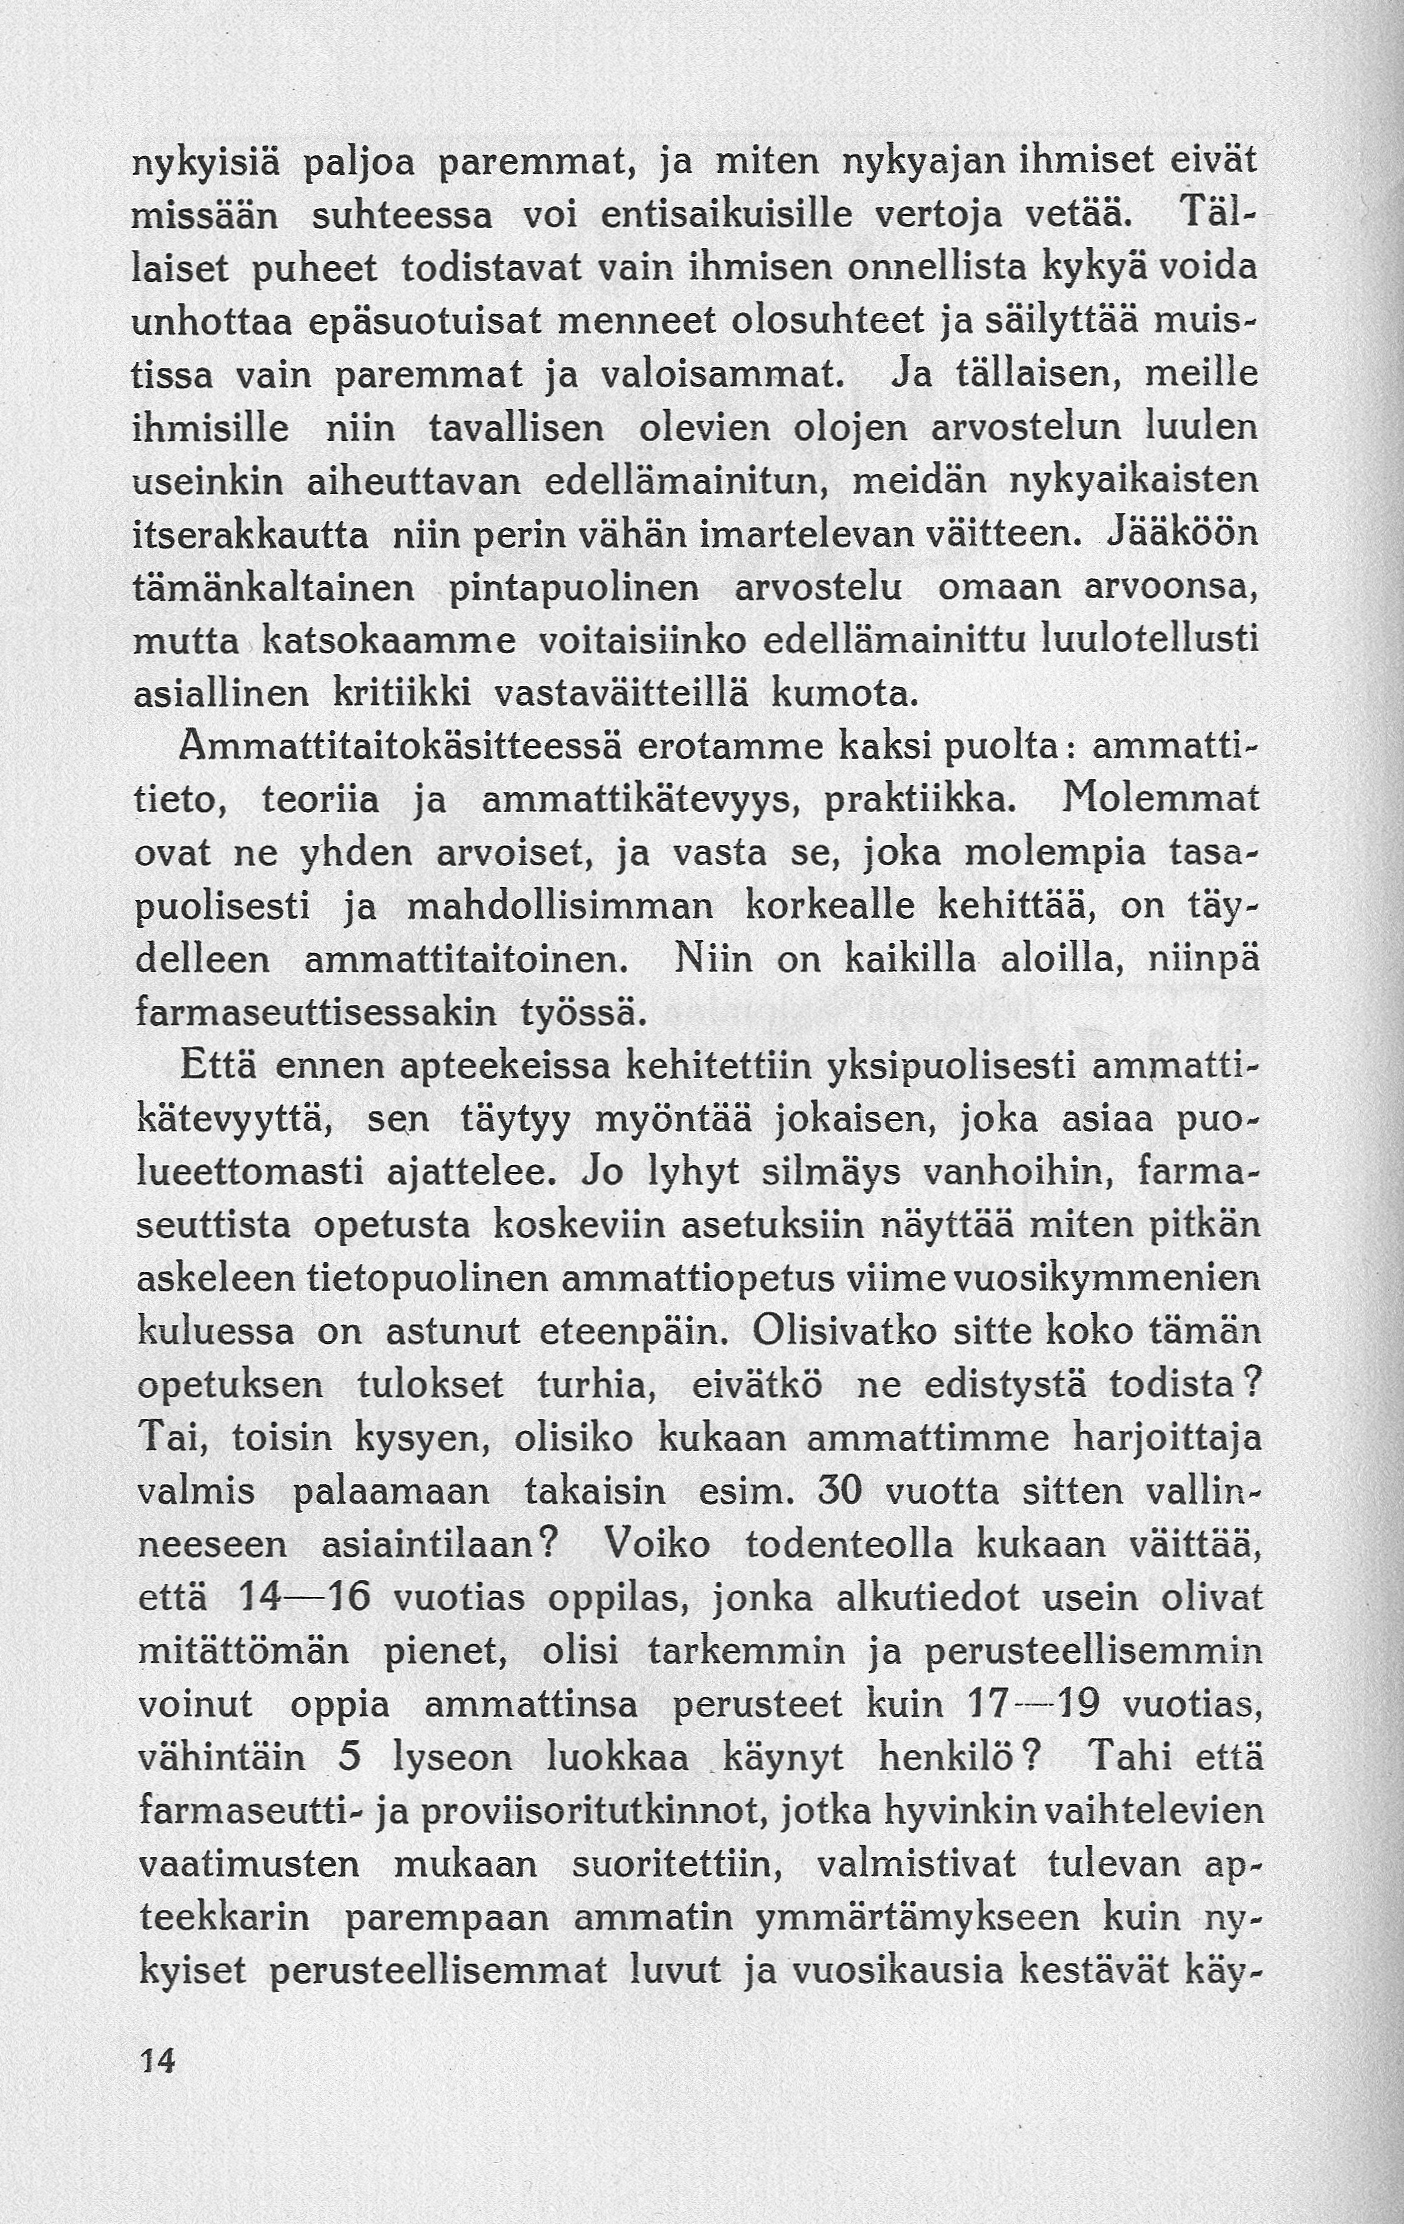

In [25]:
example = image_to_pil("nlf_ocr_groundtruth_fi/0024-8045_1910-01-01_9_18.tif")
example

I need essentially the text content of the Alto files, so let's extract that. The main thing that needs attention is the hyphenation.

In [44]:
def extract_text(page_path):

    alto_content = read_alto(page_path)
    
    whole_text = []

    for line in alto_content:

        if line['text'].isdigit() is False:

            if line['hyphenated'] == False:

                whole_text.append(f"{line['text']} ")

            else:

                whole_text.append(line['text'])
                
    return(''.join(whole_text))

This looks good enough. Not perfect, but the problems there are, i.e. numbers, are something that we don't care about with Common Voice anyway.

In [45]:
extract_text('nlf_ocr_groundtruth_fi/0024-8045_1910-01-01_9_18-gt2.xml')

'nykyisiä paljoa paremmat, ja miten nykyajan ihmiset eivät missään suhteessa voi entisaikuisille vertoja vetää. Tällaiset puheet todistavat vain ihmisen onnellista kykyä voida unhottaa epäsuotuisat menneet olosuhteet ja säilyttää muistissa vain paremmat ja valoisammat. Ja tällaisen, meille ihmisille niin tavallisen olevien olojen arvostelun luulen useinkin aiheuttavan edellämainitun, meidän nykyaikaisten itserakkautta niin perin vähän imartelevan väitteen. Jääköön tämänkaltainen pintapuolinen arvostelu omaan arvoonsa, mutta katsokaamme voitaisiinko edellämainittu luulotellusti asiallinen kritiikki vastaväitteillä kumota. Ammattitaitokäsitteessä erotamme kaksi puolta: ammattitieto, teoriia ja ammattikätevyys, praktiikka. Molemmat ovat ne yhden arvoiset, ja vasta se, joka molempia tasapuolisesti ja mahdollisimman korkealle kehittää, on täydelleen ammattitaitoinen, Niin on kaikilla aloilla, niinpä farmaseuttisessakin työssä. Että ennen apteekeissa kehitettiin yksipuolisesti ammattikätevyy

In [60]:
newspapers = []

for page_xml in Path().glob('nlf_ocr_groundtruth_fi/*xml'):
    
    page = {}
    
    page['text'] = extract_text(page_xml)
    page['source'] = page_xml
    
    newspapers.append(page)

These sentences are little bit archaic Finnish, so not all sentences are that useful for us. So let's pick only those in which a modern Finnish morphological analyser can provide an analysis for every word. 

In [ ]:
from uralicNLP import uralicApi

In [77]:
def is_finnish_word(form):
    
    result = uralicApi.analyze(form, "fin")
    
    if len(result) == 0:
        
        return(False)
    
    else:
        
        return(True)

To make it work fast enough the models have to be downloaded.

In [80]:
uralicApi.download("fin")

Model analyser for fin was downloaded
Model analyser-norm for fin was downloaded
Model generator-desc for fin was downloaded
Model generator-norm for fin was downloaded
Model generator for fin was downloaded
Model cg for fin was downloaded
Model metadata.json for fin was downloaded


This is where we pick the sentences that match our criteria.

In [128]:
good_sentences = []

for newspaper in newspapers:
    
    sentences = sent_tokenize(newspaper['text'])
    
    for sentence in sentences:
        
        if sentence[0].isupper():
            
            tokens = word_tokenize(sentence)
            
            impossible_words = 0
            
            for token in tokens:
                
                if is_finnish_word(token) == False:
                    
                    impossible_words += 1
            
            if impossible_words == 0 and len(sentence) > 10 and len(tokens) > 1 and len(tokens) < 13 and bool(re.search(r"([A-ZÄÖ]\.|\)|\(|\d)", sentence)) == False:
            
                good_sentences.append(sentence)

In [134]:
print(len(good_sentences))

good_sentences.sort()

good_sentences[0:40]

2877


['A Granfelt.',
 'Aale Nieminen.',
 'Aamusiunaus.',
 'Absalomin kapina.',
 'Absolutisti.',
 'Adam Pesola.',
 'Adele Raiman.',
 'Adolf Tolonen.',
 'Af Enzio Reuter.',
 'Af Tor Carpelan.',
 'Afrikan lukuisain nelijalkaisten kesyttämisestä.',
 'Ah, miten uskalsi hän näin katsoa äidin kirjettä?',
 'Ah, te ette ymmärrä minua!',
 'Ahtaat kengät.',
 'Aikomus lienee painattaa teos.',
 'Aine: Päivälliset Venus Milon luona.',
 'Aine: Sampo yhdistyksestä ja elinkorkolaitoksista.',
 'Aine: Wesi.',
 'Ainoa tosi rauhan tie.',
 'Ainoastaan hiukkanen yli viiden vuoden on jälellä tuosta ajasta.',
 'Ainoastaan koetus-tukku löytyy tätä nykyä.',
 'Ainoastaan liinojen kehruuta on naisille tarjona.',
 'Ainoastaan pari haaraa siitä ja niiden toteuttaminen mainittakoon tässä.',
 'Ainoastaan sopu ja yksimielisyys tekee pienetkin kansat suuriksi.',
 'Ajatelkaapas sitä!',
 'Ajatellaan esim.',
 'Ajomiehet huomatkaa!',
 'Ajomiehet huomatkaa!',
 'Akaa ja Kylmäkoski.',
 'Akkunan edessä kauempana konttoorihuoneessa i

Looks ok! Let's save these into a file.

In [135]:
unique_sentences = list(np.unique(good_sentences))

with open('common_voice_candidates_nlf_ocr_groundtruth_fi.txt', 'w') as f:
    for sentence in unique_sentences:
        f.write("%s\n" % sentence)